<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import io
import requests
# lib to plot the data
import matplotlib.pyplot as plt
# lib to use the decompositio in the time series
from statsmodels.tsa.seasonal import seasonal_decompose
# lib to use the acf and pcf correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# lib to organize the data in data frame
from pandas import DataFrame
# lib to organize the time series by periods
from pandas import TimeGrouper

# lib to import the stocastic basic models
from statsmodels.tsa.api import Holt
# lib to import the ar model
from statsmodels.tsa.ar_model import AR

# Constants

In [0]:
H = 10
V = 20

# Monthly Sunspots

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985)

## Data

In [21]:
url='https://raw.githubusercontent.com/jamissonfreitas/IN1167/master/monthly-sunspots.csv'
data = requests.get(url).content
data = data.decode('utf-8').replace("\"","").split('\n')
data = [d.strip().split(',') for d in data][1:-1]
data[:5]

[['1749-01', '58.0'],
 ['1749-02', '62.6'],
 ['1749-03', '70.0'],
 ['1749-04', '55.7'],
 ['1749-05', '85.0']]

In [35]:
df = pd.DataFrame(
    data, 
    columns=['Month', 'Sunspots']
) 
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m', errors='coerce')
df = df.set_index(df['Month'])
serie = df['Sunspots']
serie[:10]

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
1749-06-01    83.5
1749-07-01    94.8
1749-08-01    66.3
1749-09-01    75.9
1749-10-01    75.5
Name: Sunspots, dtype: object

## Plot Serie

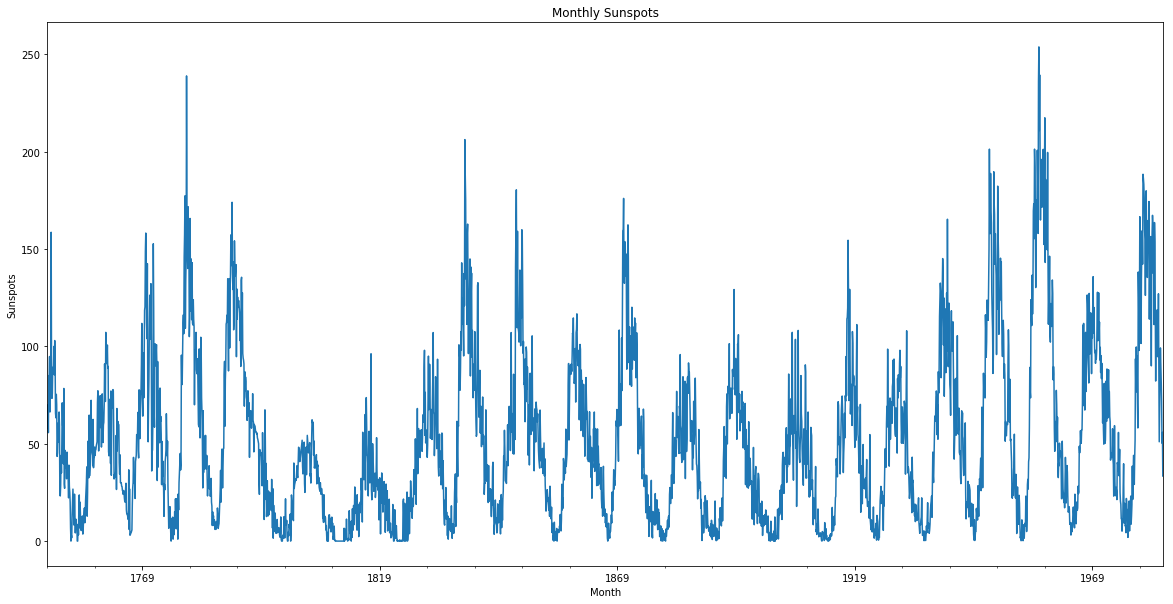

In [47]:
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.title('Monthly Sunspots')
plt.ylabel('Sunspots')
plt.xlabel('Month')
plt.show()

## ACF

<Figure size 720x1440 with 0 Axes>

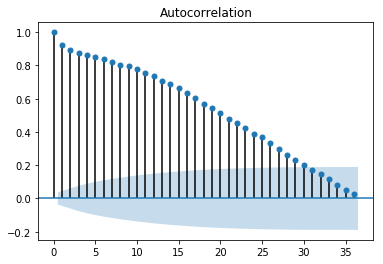

In [48]:
plt.figure(figsize=(H,V))
plot_acf(serie, lags=36)
plt.show()

## PACF

<Figure size 720x1440 with 0 Axes>

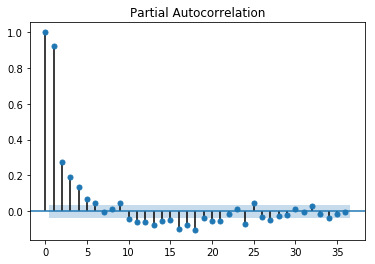

In [49]:
plot_pacf(serie, lags=36)
plt.show()

## Seasonal decompose

<Figure size 1440x720 with 0 Axes>

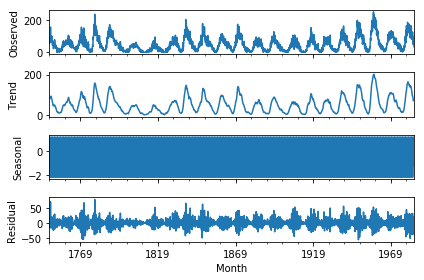

In [54]:
decompose = seasonal_decompose(serie, model='additive')
decompose.plot()
plt.show()

<Figure size 1440x720 with 0 Axes>

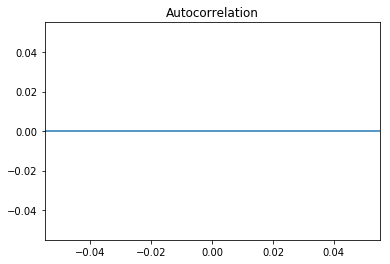

In [55]:
plot_acf(decompose.resid, lags=36)
plt.show()

## Data train and test

In [81]:
size = len(serie)
print(size)
l = int((7*size)/10)
print(l)
serie_train = serie[:l]
serie_test = serie[l:]


2820
1974


## Holt-Winters

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


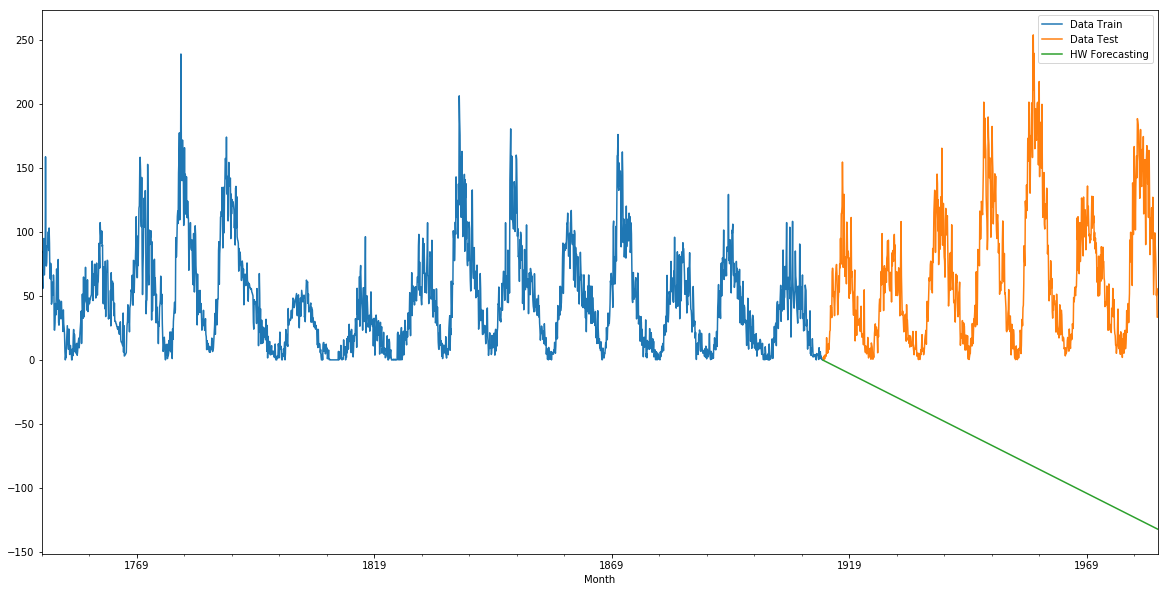

In [86]:
plt.figure(figsize=(V,H))

# fit the data
hw = Holt(serie_train).fit(smoothing_level=0.8, smoothing_slope=0.9)

# original serie
serie_train.plot(label='Data Train')

# original serie
serie_test.plot(label='Data Test')

# plot the data
# hw.fittedvalues.plot(label='HW Fit')

# predict
predict = hw.predict(start=serie_test.index[0], end=serie_test.index[-1])
predict.plot(label='HW Forecasting')

# to show the plot
# hw.forecast(25).rename('HW Forecasting').plot()
plt.legend()
plt.show()

In [87]:
from sklearn.metrics import mean_squared_error

print('MSE = ', mean_squared_error(serie_test, predict))

MSE =  22608.15671122743


## AR

In [89]:
# train AR
model = AR(serie_train)
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  25
parameters:  const           3.311481
L1.Sunspots     0.511760
L2.Sunspots     0.118378
L3.Sunspots     0.058415
L4.Sunspots     0.081358
L5.Sunspots     0.063591
L6.Sunspots     0.077502
L7.Sunspots     0.010439
L8.Sunspots     0.013952
L9.Sunspots     0.113979
L10.Sunspots   -0.002451
L11.Sunspots    0.030936
L12.Sunspots    0.020429
L13.Sunspots   -0.011019
L14.Sunspots    0.021920
L15.Sunspots    0.014468
L16.Sunspots   -0.063333
L17.Sunspots    0.015473
L18.Sunspots   -0.063316
L19.Sunspots   -0.017688
L20.Sunspots   -0.023894
L21.Sunspots   -0.053386
L22.Sunspots   -0.024675
L23.Sunspots    0.062491
L24.Sunspots   -0.068555
L25.Sunspots    0.038760
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


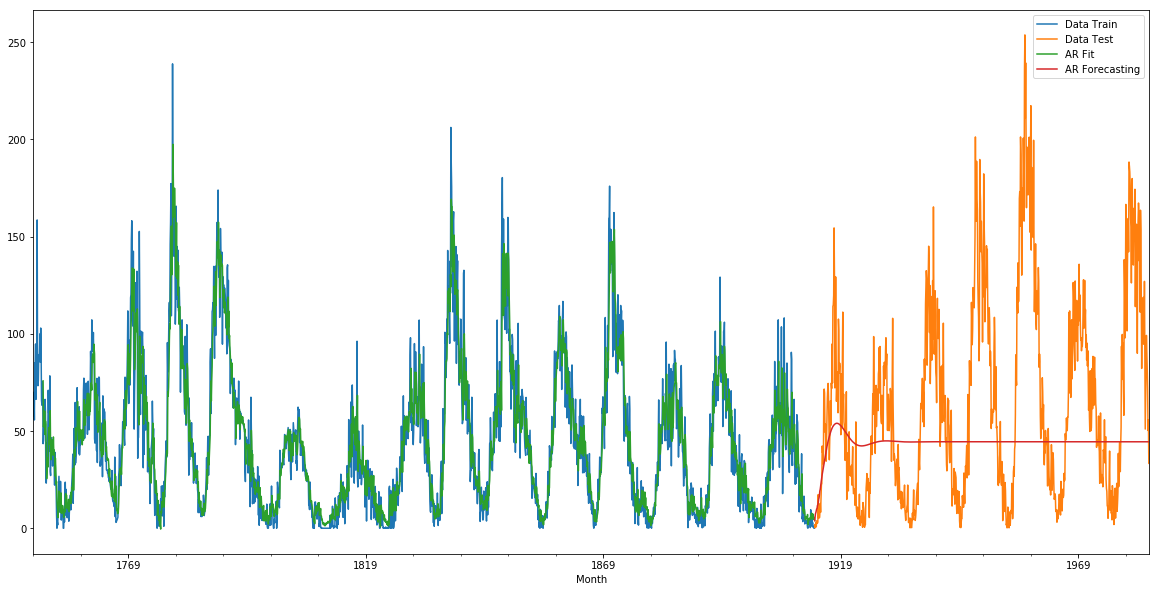

In [92]:
plt.figure(figsize=(V,H))

# plot data train and test
serie_train.plot(label='Data Train')

serie_test.plot(label='Data Test')

predict = model_fitted.predict(start=model_fitted.k_ar, end=len(serie_train), dynamic=False)
predict.plot(label='AR Fit')

predict = model_fitted.predict(start=serie_test.index[0], end=serie_test.index[-1], dynamic=False)
predict.plot(label='AR Forecasting')

#to show
plt.legend()
plt.show()

In [93]:
print('MSE = ', mean_squared_error(serie_test, predict))

MSE =  3035.861837035006


## ARMA